### Importing libraries

In [53]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

### Load Dataset

In [54]:
ds = load_dataset("benstaf/FNSPID-filtered-nasdaq-100")
df = ds["train"].to_pandas()
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358154 entries, 0 to 358153
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Unnamed: 0        358154 non-null  object             
 1   Date              358154 non-null  datetime64[ns, UTC]
 2   Article_title     358154 non-null  object             
 3   Stock_symbol      358154 non-null  object             
 4   Url               358154 non-null  object             
 5   Publisher         358154 non-null  object             
 6   Author            358154 non-null  object             
 7   Article           358154 non-null  object             
 8   Lsa_summary       358154 non-null  object             
 9   Luhn_summary      358154 non-null  object             
 10  Textrank_summary  358154 non-null  object             
 11  Lexrank_summary   358154 non-null  object             
dtypes: datetime64[ns, UTC](1), object(11)
memory

In [55]:
top_nasdaq_stocks = [
    "AAPL",   # Apple – blue-chip tech, product-driven cycles
    "MSFT",   # Microsoft – cloud growth, enterprise spending
    "NVDA",   # Nvidia – AI chip leader, highly volatile
    "GOOGL",  # Alphabet – ads, search, and cloud
    "AMZN",   # Amazon – e-commerce, cloud, macro exposure
    "META",   # Meta – ad revenue, VR/AR bets
    "TSLA",   # Tesla – retail darling, earnings-sensitive
    "AMD",    # AMD – semiconductor competition and innovation
    "INTC",   # Intel – turnaround story, chip sector proxy
    "AVGO",   # Broadcom – major in chips and infrastructure
    "PYPL",   # PayPal – fintech sentiment proxy
    "ADBE",   # Adobe – SaaS growth, creative industry
    "CMCSA",  # Comcast – media/streaming/macroeconomics link
    "PEP",    # PepsiCo – non-cyclical defensive stock
    "COST"    # Costco – strong consumer sentiment indicator
]

Selected stocks for analysis (can change)

In [56]:
df_APPL = df[df['Stock_symbol'] == "AAPL"].copy()

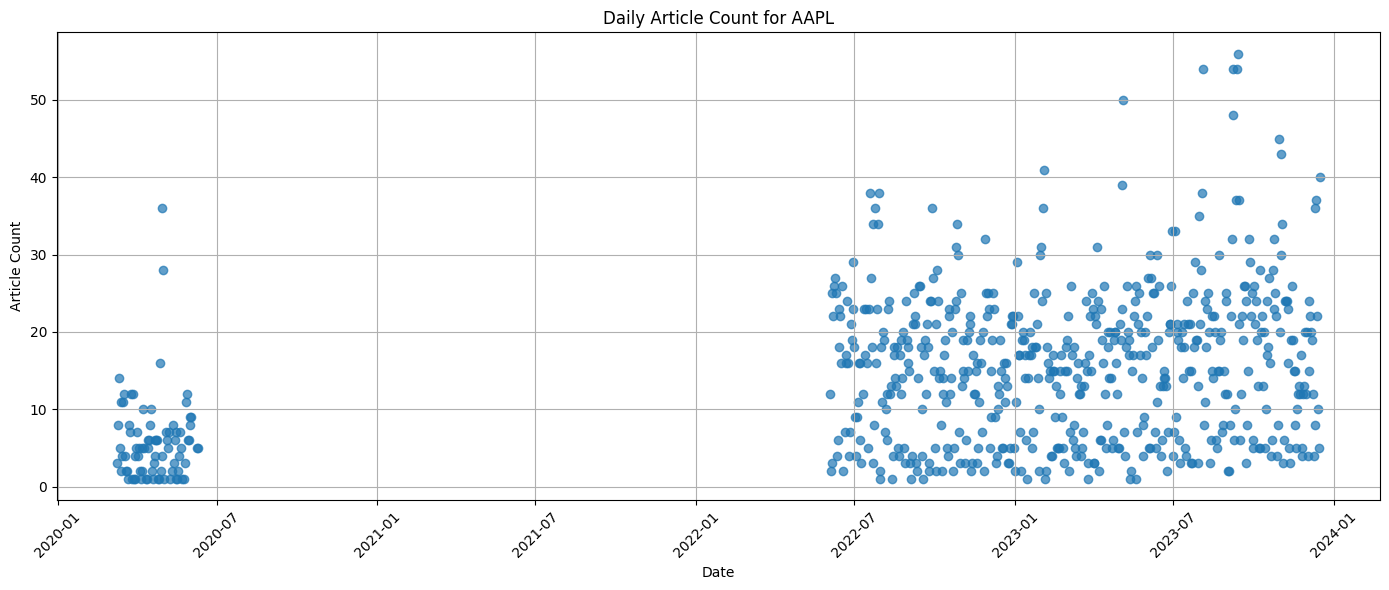

In [57]:
df_APPL['Date'] = pd.to_datetime(df_APPL['Date']).dt.tz_localize(None)

grouped_daily = df_APPL.groupby(df_APPL['Date'].dt.date).size()

plt.figure(figsize=(14, 6))
plt.scatter(grouped_daily.index, grouped_daily.values, alpha=0.7)

plt.title('Daily Article Count for AAPL')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In the case of gaps in the data—such as missing sentiment on certain days—we can still include those dates in the model by introducing a binary feature like hasSentiment. This feature indicates whether sentiment data was available for that day, allowing the model to learn the impact of sentiment when present, while still leveraging valuable price and macroeconomic data during periods without news. This approach preserves the continuity of the time series and prevents unnecessary data loss, while enabling the model to differentiate between sentiment-driven and non-sentiment-driven market behavior.

#### Function to load and filter dataset

In [58]:
def load_and_filter_fnspid(selected_symbols=None):
    ds = load_dataset("benstaf/FNSPID-filtered-nasdaq-100")
    df = ds["train"].to_pandas()

    df['Date'] = pd.to_datetime(df['Date'])

    if selected_symbols is not None:
        df = df[df['Stock_symbol'].isin(selected_symbols)].copy()
    
    return df

#### Function for sentiment analysis

In [64]:
def analyze_finbert_sentiment(df, text_columns=None, model_name="yiyanghkust/finbert-tone"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

    keep_cols = ['Date', 'Stock_symbol', 'Article_title', 'Article']
    if text_columns is None:
        text_columns = ['Lsa_summary', 'Luhn_summary', 'Textrank_summary', 'Lexrank_summary']
    df = df[keep_cols + text_columns].copy()

    label_to_score = {"positive": 1, "neutral": 0, "negative": -1}
    
    def get_average_sentiment(row):
        sentiments = []
        for col in text_columns:
            text = str(row[col])[:512]  # truncate for safety
            try:
                result = sentiment_pipeline(text)[0]
                score = label_to_score.get(result['label'].lower(), 0)
                sentiments.append(score)
            except Exception as e:
                sentiments.append(0)  # default to neutral on error
        return sum(sentiments) / len(sentiments) if sentiments else 0
    
    # Apply row-wise
    df['avg_sentiment'] = df.apply(get_average_sentiment, axis=1)
    
    return df

#### Function to aggregate daily sentiment scores

In [60]:
def aggregate_daily_sentiment(df, sentiment_column='avg_sentiment'):
    df_daily = (
        df.groupby(['Stock_symbol', 'Date'])
          .agg(
              daily_sentiment=(sentiment_column, 'mean'),
              article_count=(sentiment_column, 'count'),
              sentiment_std=(sentiment_column, 'std')  
          )
          .reset_index()
    )
    
    return df_daily

In [65]:
df_appl_subset = df_APPL.head(100)
df_appl_sentiment_subset = analyze_finbert_sentiment(df_appl_subset)
df_appl_daily_sentiment = aggregate_daily_sentiment(df_appl_sentiment_subset)
print(df_appl_daily_sentiment.head())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  Stock_symbol       Date  daily_sentiment  article_count  sentiment_std
0         AAPL 2023-12-12         0.402174             23       0.567786
1         AAPL 2023-12-13         0.295455             22       0.670982
2         AAPL 2023-12-14         0.600000             10       0.474342
3         AAPL 2023-12-15         0.650000              5       0.285044
4         AAPL 2023-12-16         0.118421             19       0.567453
